## 환경변수 로드

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## Parent 상단 그래프 생성

In [2]:
from layoutparse.teddynote_parser import create_upstage_parser_graph

# 그래프 생성
upstage_parser_graph = create_upstage_parser_graph(
    batch_size=30, test_page=None, verbose=True
)

## Parent 하단 그래프 생성

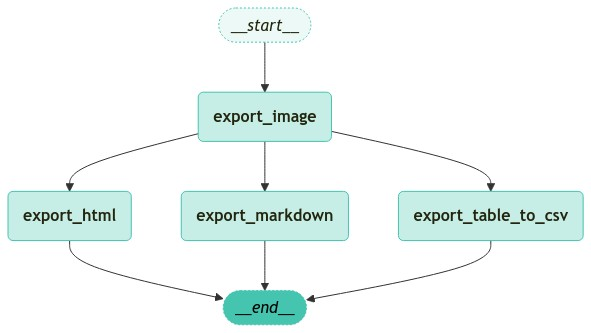

In [3]:
from langgraph.graph import StateGraph, END
from layoutparse.state import ParseState
import layoutparse.export as export
from langchain_teddynote.graphs import visualize_graph


def create_export_graph(
    ignore_new_line_in_text=True,
    show_image_in_markdown=False,
    verbose=True,
    visualize=False,
):
    """
    문서 내보내기를 위한 그래프를 생성하는 함수입니다.

    Args:
        ignore_new_line_in_text (bool): 텍스트에서 줄바꿈을 무시할지 여부
        show_image_in_markdown (bool): 마크다운에 이미지를 표시할지 여부
        verbose (bool): 상세 로그를 출력할지 여부
        visualize (bool): 그래프를 시각화할지 여부

    Returns:
        StateGraph: 컴파일된 내보내기 그래프
    """
    # 후처리 워크플로우를 생성합니다
    export_workflow = StateGraph(ParseState)

    # 이미지 내보내기 노드를 생성합니다
    export_image = export.ExportImage(verbose=verbose)
    # HTML 내보내기 노드를 생성합니다
    export_html = export.ExportHTML(
        ignore_new_line_in_text=ignore_new_line_in_text, verbose=verbose
    )
    # 마크다운 내보내기 노드를 생성합니다
    export_markdown = export.ExportMarkdown(
        ignore_new_line_in_text=ignore_new_line_in_text,
        show_image=show_image_in_markdown,
        verbose=verbose,
    )
    # CSV 테이블 내보내기 노드를 생성합니다
    export_table_csv = export.ExportTableCSV(verbose=verbose)

    # 각 내보내기 노드를 워크플로우에 추가합니다
    export_workflow.add_node("export_image", export_image)
    export_workflow.add_node("export_html", export_html)
    export_workflow.add_node("export_markdown", export_markdown)
    export_workflow.add_node("export_table_to_csv", export_table_csv)

    # 이미지 노드에서 다른 노드로의 연결을 설정합니다
    export_workflow.add_edge("export_image", "export_html")
    export_workflow.add_edge("export_image", "export_markdown")
    export_workflow.add_edge("export_image", "export_table_to_csv")

    # 각 노드에서 종료 지점으로의 연결을 설정합니다
    export_workflow.add_edge("export_html", END)
    export_workflow.add_edge("export_markdown", END)
    export_workflow.add_edge("export_table_to_csv", END)

    # 워크플로우의 시작점을 이미지 내보내기로 설정합니다
    export_workflow.set_entry_point("export_image")

    # 워크플로우를 컴파일하고 필요시 시각화합니다
    export_graph = export_workflow.compile()
    if visualize:
        visualize_graph(export_graph)
    return export_graph

# export 그래프를 생성합니다
export_graph = create_export_graph(show_image_in_markdown=True, visualize=True)

## 상단-하단 그래프 붙이기

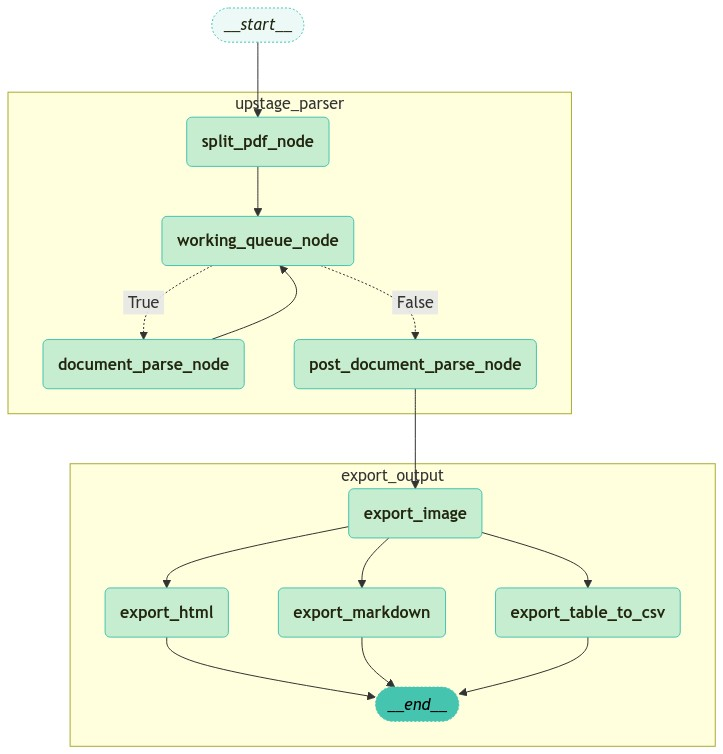

In [4]:
# 체크포인트 저장을 위한 MemorySaver를 임포트합니다
from langgraph.checkpoint.memory import MemorySaver

"""
전체 문서 처리 워크플로우를 구성하는 부분입니다.
업스테이지 파서와 내보내기 기능을 연결하여 하나의 그래프로 만듭니다.
"""

# StateGraph를 사용하여 전체 워크플로우의 뼈대를 생성합니다
parent_workflow = StateGraph(ParseState)

# 업스테이지 파서 노드를 워크플로우에 추가합니다 - PDF 파싱을 담당합니다
parent_workflow.add_node("upstage_parser", upstage_parser_graph)
# 내보내기 노드를 워크플로우에 추가합니다 - 파싱된 결과를 다양한 형식으로 저장합니다
parent_workflow.add_node("export_output", export_graph)

# 파서에서 내보내기로 데이터가 흐르도록 엣지를 연결합니다
parent_workflow.add_edge("upstage_parser", "export_output")

# 워크플로우의 시작점을 파서로 지정합니다
parent_workflow.set_entry_point("upstage_parser")

# 메모리 체크포인터를 사용하여 워크플로우를 컴파일합니다
parent_graph = parent_workflow.compile(checkpointer=MemorySaver())

# 생성된 그래프를 시각화하여 확인합니다 (xray 옵션으로 상세 정보 표시)
visualize_graph(parent_graph, xray=True)

## 그래프 실행
- `./data/PDF 파일명.pdf` <- 경로를 지켜주세요.


- 그래프 실행 결과 json, md, html, images, tables 파일들이 생깁니다.

In [5]:
import uuid
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph

# 옵션 설정
config = RunnableConfig(
    recursion_limit=300,
    configurable={"thread_id": str(uuid.uuid4())},
)

# filepath: 분석할 PDF 파일의 경로
inputs = {
    "filepath": "data/20241113_company_491011000.pdf",
}

# 그래프를 실행합니다
stream_graph(parent_graph, inputs, config=config)

[SplitPDFNode] 파일의 전체 페이지 수: 5 Pages.
[SplitPDFNode] 분할 PDF 생성: data/20241113_company_491011000_0000_0004.pdf
[DocumentParseNode] Start Parsing: data/20241113_company_491011000_0000_0004.pdf
[DocumentParseNode] Finished Parsing in 19.58 seconds
[PostDocumentParseNode] Total Post-processed Elements: 66
[PostDocumentParseNode] Total Cost: $0.05
[ExportMarkdown] 마크다운 파일이 성공적으로 생성되었습니다: /home/hantaek/teddynotes/parser2/data/20241113_company_491011000.md
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /home/hantaek/teddynotes/parser2/data/tables/20241113_COMPANY_491011000_TABLE_Page_0_Index_8.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /home/hantaek/teddynotes/parser2/data/tables/20241113_COMPANY_491011000_TABLE_Page_0_Index_10.csv
[ExportHTML] HTML 파일이 성공적으로 생성되었습니다: data/20241113_company_491011000.html
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /home/hantaek/teddynotes/parser2/data/tables/20241113_COMPANY_491011000_TABLE_Page_0_Index_18.csv
[ExportTableCSV] CSV 파일이 성공적으로 생성되었습니다: /home/hantaek/teddy

## 마크다운 파일 로드
 
- PDF -> 파서(Parent Graph) -> 파일 자동저장 -> {현재 상황} -> data 폴더에 생긴 마크다운 파일(.md) 로드하기

In [7]:
from pathlib import Path
from typing import List
from langchain.schema import Document

def load_markdown_file(file_path: str) -> List[Document]:
    """마크다운 파일을 로드하여 Document 객체 리스트로 변환"""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Document 객체 생성
    document = Document(
        page_content=content,
        metadata={
            "source": file_path,
            "file_type": "markdown"
        }
    )
    
    return [document]

# 마크다운 파일 로드
file_path = "./data/20241113_company_491011000.md"  # 실제 파일 경로로 변경 필요
pages = load_markdown_file(file_path)

## Splitter로 Load된 문서 나누기
- Langchain에서 지원하는 Document 형식으로 바꾼 .md 파일(pages변수)을 Splitter로 나누는 상황

In [22]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200,
    chunk_overlap=100,
    # separators=[
    #     "\n# ",      # 대제목 기준
    #     "\n## ",     # 중제목 기준
    #     "\n### ",    # 소제목 기준
    #     "\n|",       # 표 구분
    #     "|"          # 표 구분
    #     "\n",        # 일반 줄바꿈
    #     "\n\n",
    #     ". "         # 문장 구분
    # ]
)

# 문서 분할
splits = text_splitter.split_documents(pages)

In [26]:
splits

[Document(metadata={'source': './data/20241113_company_491011000.md', 'file_type': 'markdown'}, page_content='# 음식료\n\n# CJ제일제당 097950\n\n# 3Q24 Re: 식품 성수기, 감익이 많이 아쉽다\n\nNov 13, 2024\n\n# BUY\n\n# TP 410,000 원\n\n유지\n\n하향\n\n![](/home/hantaek/teddynotes/parser2/data/images/table/20241113_COMPANY_491011000_TABLE_Page_1_Index_8.png)\n\n| 현재가(11/12) | 256,500 원 |\n| --- | --- |\n| 액면가(원) | 5,000 원 |\n| 52 주 최고가(보통주) | 398,000 원 |\n| 52 주 최저가(보통주) | 256,500 원 |\n| KOSPI (11/12) | 2,482.57p |\n| KOSDAQ (11/12) | 710.52p |\n| 자본금 | 819 억원 |\n| 시가총액 | 40,313 억원 |\n| 발행주식수(보통주) | 1,505 만주 |\n| 발행주식수(우선주) | 133 만주 |\n| 평균거래량(60 일) | 3.4 만주 |\n| 평균거래대금(60 일) | 93 억원 |\n| 외국인지분(보통주) | 24.73% |\n| 주요주주 |  |\n| CJ 외 8 인 | 45.41% |\n| 국민연금공단 | 11.86% |\n\n\n![](/home/hantaek/teddynotes/parser2/data/images/figure/20241113_COMPANY_491011000_FIGURE_Page_1_Index_9.png)\n\n![](/home/hantaek/teddynotes/parser2/data/images/table/20241113_COMPANY_491011000_TABLE_Page_1_Index_10.png)\n\n| 주가수익률(%) | 1 개월 | 